## Download and decode tests

### Instance type = c5.24xlarge

In [1]:
!pip install boto3 matplotlib aioboto3 aiobotocore numcodecs psutil
import boto3
import aioboto3
from botocore.config import Config
import matplotlib.pyplot as plt
import time
from concurrent.futures import ThreadPoolExecutor
import os
import platform
import psutil
from datetime import datetime

In [2]:

def get_size(bytes):
    """
    Convert bytes to human readable format
    """
    for unit in ['', 'K', 'M', 'G', 'T', 'P']:
        if bytes < 1024:
            return f"{bytes:.2f}{unit}B"
        bytes /= 1024
        
def get_cpu_info():
    """
    Extract CPU information from /proc/cpuinfo
    """
    cpu_info = {}
    try:
        with open('/proc/cpuinfo', 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.strip():
                    key, value = line.split(':', 1)
                    cpu_info[key.strip()] = value.strip()
    except Exception as e:
        return f"Error reading CPU info: {str(e)}"
    
    return cpu_info
def print_system_info():
    print("\n=== System Information Analysis ===")
    print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # CPU Information
    cpu_info = get_cpu_info()
    print("\n--- CPU Details ---")
    print(f"CPU Model: {cpu_info.get('model name', 'Unknown')}")
    print(f"CPU Cores: {psutil.cpu_count(logical=False)} (Physical), {psutil.cpu_count()} (Logical)")
    print(f"CPU Frequency: {psutil.cpu_freq().current:.2f}MHz")
    print(f"CPU Usage: {psutil.cpu_percent()}%")

    # Memory Information
    memory = psutil.virtual_memory()
    print("\n--- Memory Details ---")
    print(f"Total RAM: {get_size(memory.total)}")
    print(f"Available RAM: {get_size(memory.available)}")
    print(f"Used RAM: {get_size(memory.used)} ({memory.percent}%)")
print_system_info()


=== System Information Analysis ===
Timestamp: 2024-12-05 14:18:53

--- CPU Details ---
CPU Model: Intel(R) Xeon(R) Platinum 8275CL CPU @ 3.00GHz
CPU Cores: 48 (Physical), 96 (Logical)
CPU Frequency: 2883.48MHz
CPU Usage: 2.7%

--- Memory Details ---
Total RAM: 184.86GB
Available RAM: 177.22GB
Used RAM: 6.26GB (4.1%)


In [3]:
s3_client = boto3.client('s3', config=Config(max_pool_connections=512))

In [4]:
bucket="lifebit-user-data-1f2bfdf2-1d99-488c-9b87-246c62b66ea7"

In [5]:
keys = [f"GEL-256534/call_genotype/{i}/{j}/0" for i in range(4000) for j in range(16)]

In [6]:
from numcodecs.blosc import Blosc
from numcodecs import blosc
blosc.init()
blosc.set_nthreads(1)
#Need to call this twice, not sure why!
blosc.set_nthreads(1)

1

## Each process is given a batch of chunks to fetch, then async fecthes in it's main thread before handing over to decode in a set of threads as the chunks come in.

In [7]:
import asyncio
import aioboto3
import multiprocessing as mp
from collections import defaultdict
import time
import os
from typing import List, Dict
import statistics
from dataclasses import dataclass
from concurrent.futures import ProcessPoolExecutor

@dataclass
class BatchStats:
    process_id: int
    start_time: float
    total_bytes: int
    data_bytes: int
    files_completed: int
    duration: float = None
    
class S3BulkFetcher:
    def __init__(self, bucket: str, keys: List[str], num_processes: int = None, batch_size: int = 500, decode_threads=8):
        self.bucket = bucket
        self.keys = keys
        self.num_processes = num_processes or mp.cpu_count()
        self.batch_size = batch_size
        self.work_queue = mp.Queue()
        self.stats_queue = mp.Queue()
        self.decode_threads = decode_threads
        
    def prepare_batches(self):
        batches = [
            self.keys[i:i+self.batch_size] 
            for i in range(0, len(self.keys), self.batch_size)
        ]
        for batch in batches:
            self.work_queue.put(batch)
            
        for _ in range(self.num_processes):
            self.work_queue.put(None)
    
    async def process_batch(self, batch: List[str], session, decoder, thread_pool) -> BatchStats:
        stats = BatchStats(
            process_id=os.getpid(),
            start_time=time.time(),
            total_bytes=0,
            data_bytes=0,
            files_completed=0
        )
        
        async with session.client('s3') as s3:
            async def fetch_single(key: str):
                response = await s3.get_object(Bucket=self.bucket, Key=key)
                raw_data = await response['Body'].read()
                return raw_data
            loop = asyncio.get_running_loop()

            def decode(raw_data):
                return len(decoder.decode(raw_data))
            
            decompression_tasks = []
            for raw_data in asyncio.as_completed(
                [fetch_single(key) for key in batch]
            ):
                raw_data = await raw_data
                
                decompression_future = loop.run_in_executor(
                    thread_pool,
                    decode,
                    raw_data
                )
                decompression_tasks.append((len(raw_data), decompression_future))
            for len_raw_data, decompression_future in decompression_tasks:
                len_data = await decompression_future
                stats.total_bytes += len_raw_data
                stats.data_bytes += len_data
                stats.files_completed += 1                
                    
        stats.duration = time.time() - stats.start_time
        return stats
    
    async def worker_loop(self):
        session = aioboto3.Session()
        decoder = Blosc.from_config({'cname': 'zstd', 'clevel': 7, 'shuffle': 2, 'blocksize': 0})
        thread_pool = ThreadPoolExecutor(max_workers=self.decode_threads)
        while True:
            batch = self.work_queue.get()
            if batch is None:  # sentinel value
                break
                
            stats = await self.process_batch(batch, session, decoder, thread_pool)
            self.stats_queue.put(stats)
        thread_pool.shutdown(wait=True)

    def worker_process(self):
        asyncio.run(self.worker_loop())

    def print_final_stats(self, all_stats: List[BatchStats], wall_time: float):
        total_bytes = sum(s.total_bytes for s in all_stats)
        total_data = sum(s.data_bytes for s in all_stats)
        total_files = sum(s.files_completed for s in all_stats)
        
        process_stats = defaultdict(lambda: {'bytes': 0, 'data':0, 'files': 0, 'batches': 0})
        for stat in all_stats:
            process_stats[stat.process_id]['bytes'] += stat.total_bytes
            process_stats[stat.process_id]['data'] += stat.data_bytes
            process_stats[stat.process_id]['files'] += stat.files_completed
            process_stats[stat.process_id]['batches'] += 1

        batch_times = [s.duration for s in all_stats]
        
        # print("\n=== S3 Bulk Download Statistics ===")
        # print(f"\nOverall Performance:")
        # print(f"Total transfer: {total_bytes / 1000 / 1000:.2f} MB in {total_files} files")
        # print(f"Total data: {total_data / 1000 / 1000:.2f} MB in {total_files} chnnks")
        # print(f"Duration: {wall_time:.2f} seconds")
        # print(f"Throughput: {(total_bytes / 1000 / 1000) / wall_time:.2f} MB/s, "
        #      f"{total_files / wall_time:.1f} files/s")
        # print(f"Data Throughput: {(total_data / 1000 / 1000) / wall_time:.2f} MB/s, "
        #      f"{total_files / wall_time:.1f} chunks/s")
        
        # print("\nBatch Statistics:")
        # print(f"Batch times - min: {min(batch_times):.2f}s, "
        #      f"max: {max(batch_times):.2f}s, "
        #      f"avg: {statistics.mean(batch_times):.2f}s")
        
        # print("\nPer-Process Performance:")
        # for pid, stats in process_stats.items():
        #    print(f"Process {pid}:")
        #    print(f"  Throughput: {(stats['bytes'] / 1000 / 1000) / wall_time:.2f} MB/s, "
        #          f"{stats['files'] / wall_time:.1f} files/s")
        #    print(f"  Data Throughput: {(stats['data'] / 1000 / 1000) / wall_time:.2f} MB/s, "
        #          f"{stats['files'] / wall_time:.1f} chunks/s")
        #    print(f"  Processed: {stats['files']} files in {stats['batches']} batches")

    def run(self):
        start_time = time.time()
        
        # Prepare work batches
        self.prepare_batches()
        
        # Start worker processes
        processes = []
        for _ in range(self.num_processes):
            p = mp.Process(target=self.worker_process)
            p.start()
            processes.append(p)
            
        # Collect all stats
        all_stats = []
        stats_to_collect = len([b for b in self.keys[::self.batch_size]])
        
        while len(all_stats) < stats_to_collect:
            stats = self.stats_queue.get()
            all_stats.append(stats)
            
            # Optional: Print progress
            #if len(all_stats) % 10 == 0:
            #    print(f"Progress: {len(all_stats)}/{stats_to_collect} batches complete")
        
        # Wait for all processes to complete
        for p in processes:
            p.join()
            
        wall_time = time.time() - start_time
        
        # Print final statistics
        self.print_final_stats(all_stats, wall_time)
        
        return all_stats



In [8]:
import math 

def run_scaling_benchmark(
    fetcher_class,
    bucket,
    keys,
    batch_size,
    min_processes,
    max_processes,
    max_decode_threads
):
    process_counts = []
    throughputs = []
    data_throughputs = []
    
    n_proc = min_processes
    
    while n_proc <= max_processes:
        n_decode_threads = min(math.ceil(96/n_proc), max_decode_threads)
        print(f"\nTesting with {n_proc} processes with {n_decode_threads} threads each...")
        fetcher = fetcher_class(
            bucket=bucket,
            keys=keys[:n_proc*batch_size*32],
            num_processes=n_proc,
            batch_size=batch_size,
            decode_threads=n_decode_threads
        )
        
        start_time = time.time()
        stats = fetcher.run()
        duration = time.time() - start_time
        
        total_bytes = sum(s.total_bytes for s in stats)
        throughput = (total_bytes / 1000 / 1000) / duration  # MB/s
        total_data = sum(s.data_bytes for s in stats)
        data_throughput = (total_data / 1000 / 1000) / duration  # MB/s
        
        process_counts.append(n_proc)
        throughputs.append(throughput)
        data_throughputs.append(data_throughput)
        
        print(f"Throughput with {n_proc} processes: {throughput:.2f} MB/s")
        print(f"Data Throughput with {n_proc} processes: {data_throughput:.2f} MB/s")
        
        n_proc *= 2
        
    return process_counts, throughputs, data_throughputs

def plot_scaling(process_counts, throughputs, data_throughputs, title= "S3 Throughput Scaling"):
    plt.figure(figsize=(10, 6))
    # plt.plot(process_counts, throughputs, 'bo-', linewidth=2, markersize=8)
    plt.plot(process_counts, data_throughputs, 'bo-', linewidth=2, markersize=8)
    
    plt.xscale('log', base=2)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.xlabel("Number of Processes")
    plt.ylabel("Decompressed Throughput (MB/s)")
    plt.title(title)
    
    plt.legend()
    plt.tight_layout()


## Firstly let's test with one decode thread per process


Testing with 1 processes with 1 threads each...
Throughput with 1 processes: 4.29 MB/s
Data Throughput with 1 processes: 1447.61 MB/s

Testing with 2 processes with 1 threads each...
Throughput with 2 processes: 7.85 MB/s
Data Throughput with 2 processes: 2887.64 MB/s

Testing with 4 processes with 1 threads each...
Throughput with 4 processes: 13.41 MB/s
Data Throughput with 4 processes: 5335.05 MB/s

Testing with 8 processes with 1 threads each...
Throughput with 8 processes: 26.12 MB/s
Data Throughput with 8 processes: 10979.57 MB/s

Testing with 16 processes with 1 threads each...
Throughput with 16 processes: 56.09 MB/s
Data Throughput with 16 processes: 22007.83 MB/s

Testing with 32 processes with 1 threads each...
Throughput with 32 processes: 100.52 MB/s
Data Throughput with 32 processes: 40043.31 MB/s

Testing with 64 processes with 1 threads each...
Throughput with 64 processes: 123.81 MB/s
Data Throughput with 64 processes: 49322.39 MB/s

Testing with 128 processes with 1 

/tmp/ipykernel_11467/2020954492.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


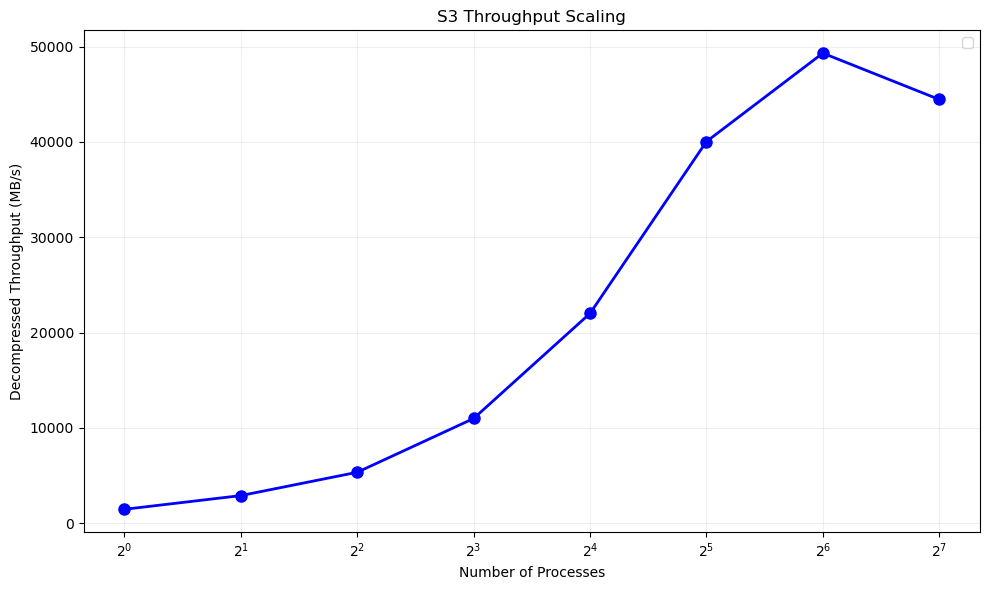

In [9]:
process_counts, throughputs, data_throughputs = run_scaling_benchmark(
        S3BulkFetcher,
        bucket=bucket,
        keys=keys,
        batch_size=100,
        min_processes=1,
        max_processes=128,
        max_decode_threads=1
    )
print(process_counts, throughputs, data_throughputs)
plot_scaling(process_counts, throughputs, data_throughputs)

## This time split the logical cores up for each process to use in the decode threads.


Testing with 1 processes with 96 threads each...
Throughput with 1 processes: 12.23 MB/s
Data Throughput with 1 processes: 4126.58 MB/s

Testing with 2 processes with 48 threads each...
Throughput with 2 processes: 21.45 MB/s
Data Throughput with 2 processes: 7891.25 MB/s

Testing with 4 processes with 24 threads each...
Throughput with 4 processes: 38.23 MB/s
Data Throughput with 4 processes: 15214.57 MB/s

Testing with 8 processes with 12 threads each...
Throughput with 8 processes: 64.50 MB/s
Data Throughput with 8 processes: 27113.45 MB/s

Testing with 16 processes with 6 threads each...
Throughput with 16 processes: 107.62 MB/s
Data Throughput with 16 processes: 42226.29 MB/s

Testing with 32 processes with 3 threads each...
Throughput with 32 processes: 121.38 MB/s
Data Throughput with 32 processes: 48352.93 MB/s

Testing with 64 processes with 2 threads each...
Throughput with 64 processes: 112.93 MB/s
Data Throughput with 64 processes: 44985.76 MB/s

Testing with 128 processes

/tmp/ipykernel_11467/2020954492.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


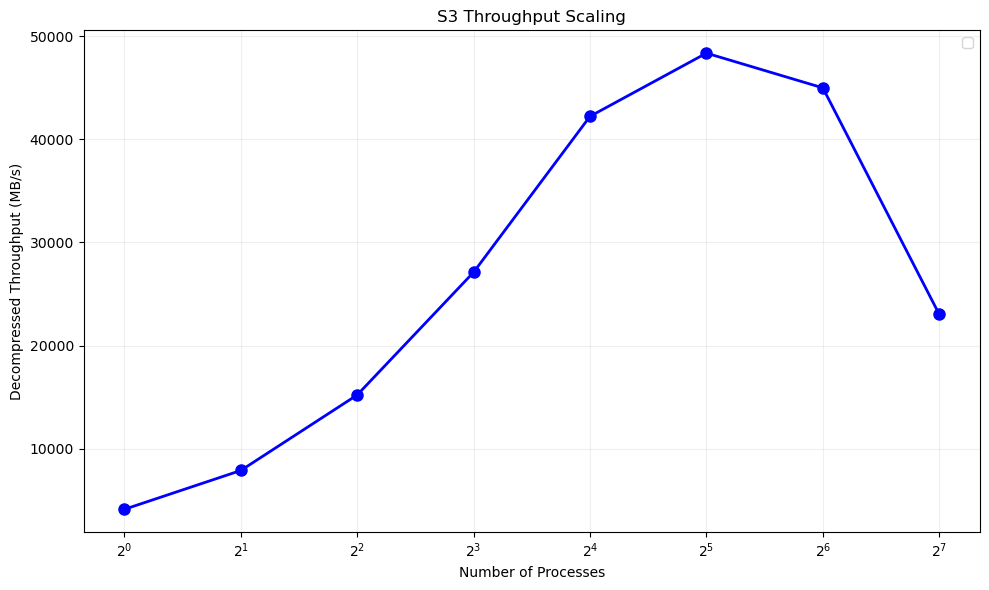

In [10]:
process_counts, throughputs, data_throughputs = run_scaling_benchmark(
        S3BulkFetcher,
        bucket=bucket,
        keys=keys,
        batch_size=100,
        min_processes=1,
        max_processes=128,
        max_decode_threads=1000
    )
print(process_counts, throughputs, data_throughputs)
plot_scaling(process_counts, throughputs, data_throughputs)